# Outline

We used the drift diffusion model (ddm) to analyze the results of a simple perceptual decision-making task, which consisted of response time (rt) and response data. 

The ddm can decompose the latent cognitive process into seven parameters: drift rate (v), starting point (z), decision boundary (a), non-decision time (t), and their variabilities (sv, sz, st). 

One of the challenges we faced was to choose the best response coding method for our data, as different methods can lead to different distributions that affect the parameter estimation. We compared two response coding methods: accuracy coding and stimulus coding.

The aim of this script is to determine which response coding method is more suitable for our data.


We use a tree structure to illustrate the impact of the different steps

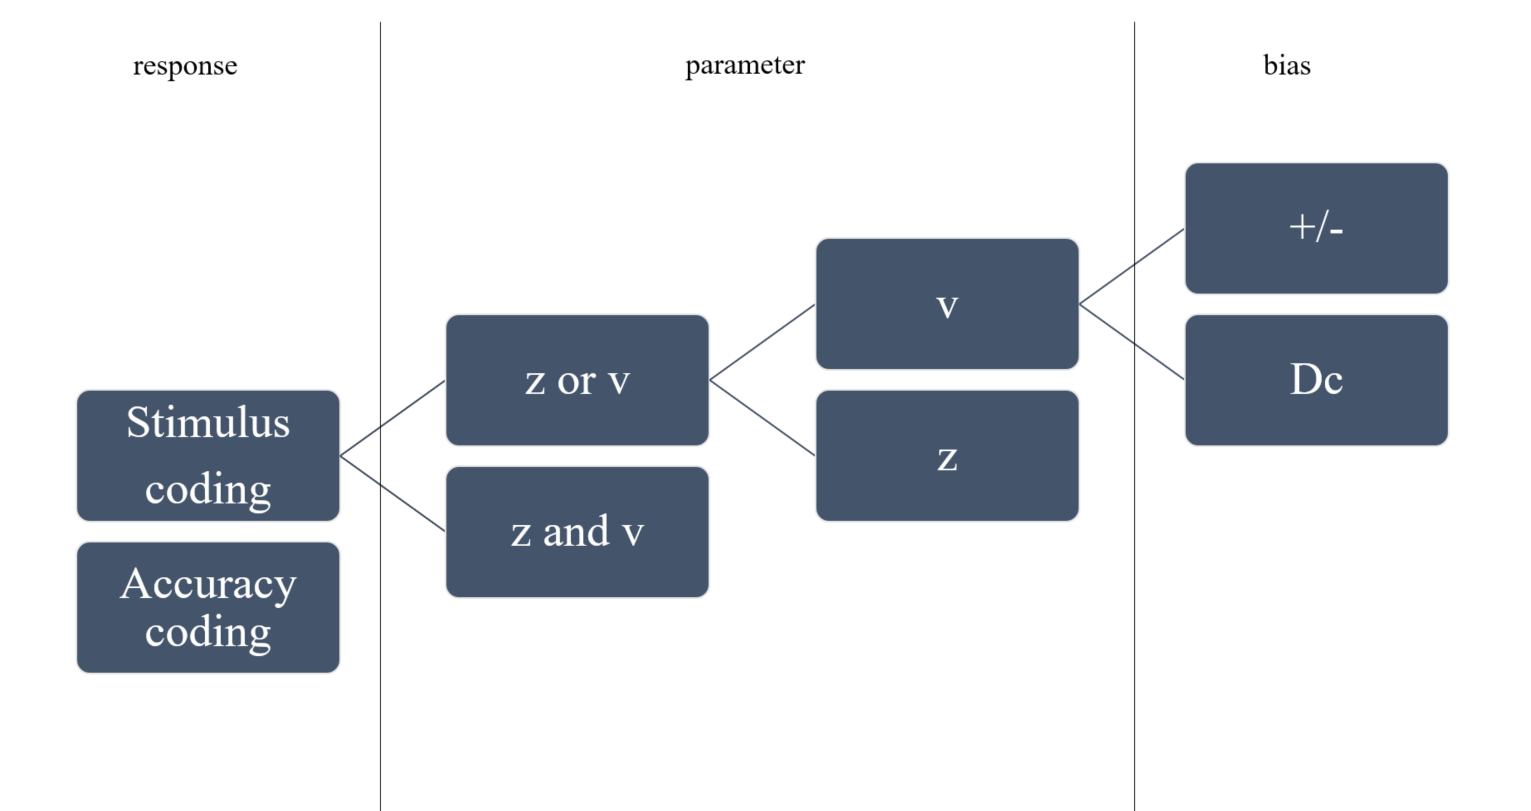

Accuracy coding eliminates the influence of the stimulus, while stimulus coding requires considering the influence of the stimulus. 

Therefore, if we use accuracy coding, we do not need to consider the of bias of stimulus. However, if we use stimulus coding, we need to consider how stimulus affects the parameters and generate bias.
   
Previous literature has suggested that the stimulus bias may affect two parameters: `v`  and `z`.

The first problem we need to address is whether both parameters are influenced by the stimulus bias or only one parameter is.

If both parameters are influenced, we need to account for two scouces of bias. If only one parameter is influenced, we need to select which parameter is affected.

When `z` is influenced by the stimulus bias, it means that `z` for stimulus A and `1-z` for stimulus B are different.

When `v` is influenced by the stimulus bias, it means that `v+dc` for stimulus A and `-v+dc` for stimulus B are different, where dc is the bias term. These two cases are essentially equivalent. We can assume that `z = 1/2 + zbias` , then `1-z = 1/2 - zbias`. 

However, in this analysis, we made some implicit assumptions that need to be clarified:

Assumption 1: `zbias` and `vbias` cannot coexist at the same time. The reason for this assumption is unknown. Therefore, when both `z` and `v` are influenced by stimulus coding, only `zbias` exists but not `vbias`. In this case, `v` has positive or negative values corresponding to each stimulus. This method is equivalent to accuracy coding.

Assumption 2: `zbias` only affects `z` and `1-z` in a symmetrical way. `vbias` affects `v` in an asymmetrical way with `+/-` or `dc`.

Based on these assumptions, we have four methods to code our results and four hypotheses to test:

- Accuracy coding

- Stimulus coding with z bias

- Stimulus coding with v bias using positive/negative values

- Stimulus coding with v bias using dc term.

# Accuracy coding

In [1]:
#system
import sys
import os
#function
import utils
#variable
from collections import OrderedDict
from copy import deepcopy
import numpy as np
import pandas as pd
from patsy import dmatrix
#plot
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
import ptitprince as pt
# model
import kabuki
import hddm
from hddm import HDDMRegressor
# stats
import bambi as bmb
# parallel processing related
from p_tqdm import p_map
from functools import partial
from joblib import Parallel,delayed

/opt/conda/lib/python3.8/site-packages/IPython/parallel.py:12: ShimWarning: The `IPython.parallel` package has been deprecated since IPython 4.0. You should import from ipyparallel instead.
  warn("The `IPython.parallel` package has been deprecated since IPython 4.0. "


In [2]:
print(f'The version of python is {sys.version}')
print(f'The version of numpy is {np.__version__}')
print(f'The version of pandas is {pd.__version__}')
print(f'The version of matplotlib is {matplotlib.__version__}')
print(f'The version of seaborn is {sns.__version__}')
print(f'The version of arviz is {az.__version__}')
print(f'The version of hddm is {hddm.__version__}')
print(f'The version of kabuki is {kabuki.__version__}')
print(f'The version of bambi is {bmb.__version__}')

The version of python is 3.8.8 | packaged by conda-forge | (default, Feb 20 2021, 16:22:27) 
[GCC 9.3.0]
The version of numpy is 1.20.3
The version of pandas is 1.3.5
The version of matplotlib is 3.3.4
The version of seaborn is 0.11.2
The version of arviz is 0.12.0
The version of hddm is 0.8.0
The version of kabuki is 0.6.4
The version of bambi is 0.8.0


In [3]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

## Generate random parameter and performance

To ensure that the code is comparable, it largely follows the code of the previous script.

The step are as follows:

- set the parameters for the simulation according to the goal of the experiment, like subjects, trials.

- generate parameters of group level.We use the function `hddm.generate.gen_rand_params()`. But we need to generate simulated data based on the way the response is coded.

    This function is from https://github.com/hddm-devs/hddm/blob/master/hddm/generate.py line 56-127,

    This function call another function gen_single_params_set() in the same document, line 11-53.

- Subject-level parameters are generated for each subject according to normal distribution based on group level parameters

    When we generate the subject-level parameters according the group-level parameters, we use the function kabuki.generate._add_noise()

    This function is from https://github.com/hddm-devs/kabuki/blob/master/kabuki/generate.py line 9-94,

    This function take the group-level parameters as the mean of a normal distribution, then set a standard deviation, and draw the subject-level parameters from that distribution. Besides, we set `bounds` to avoid unreasonable parameters.
    
    Since we are concerned with response coding, we do not need to set different effects for different conditions.
    
- Multiple iterations of parameter values of interest have been used by setting a range of parameters to test the robustness of the results.

The above sections are repeated in the various coding methods, and in the next sections we will only cover what is relevant to reaction coding.

In this scenario, we used accuracy coding to eliminate the influence of the stimulus. In other words, we assumed that individuals’ preferences for stimuli were balanced by setting appropriate boundaries. At the same time, we assumed that zbias and vbias could not coexist simultaneously, as this would make the model estimation intractable.

So we don't need to set something especially.

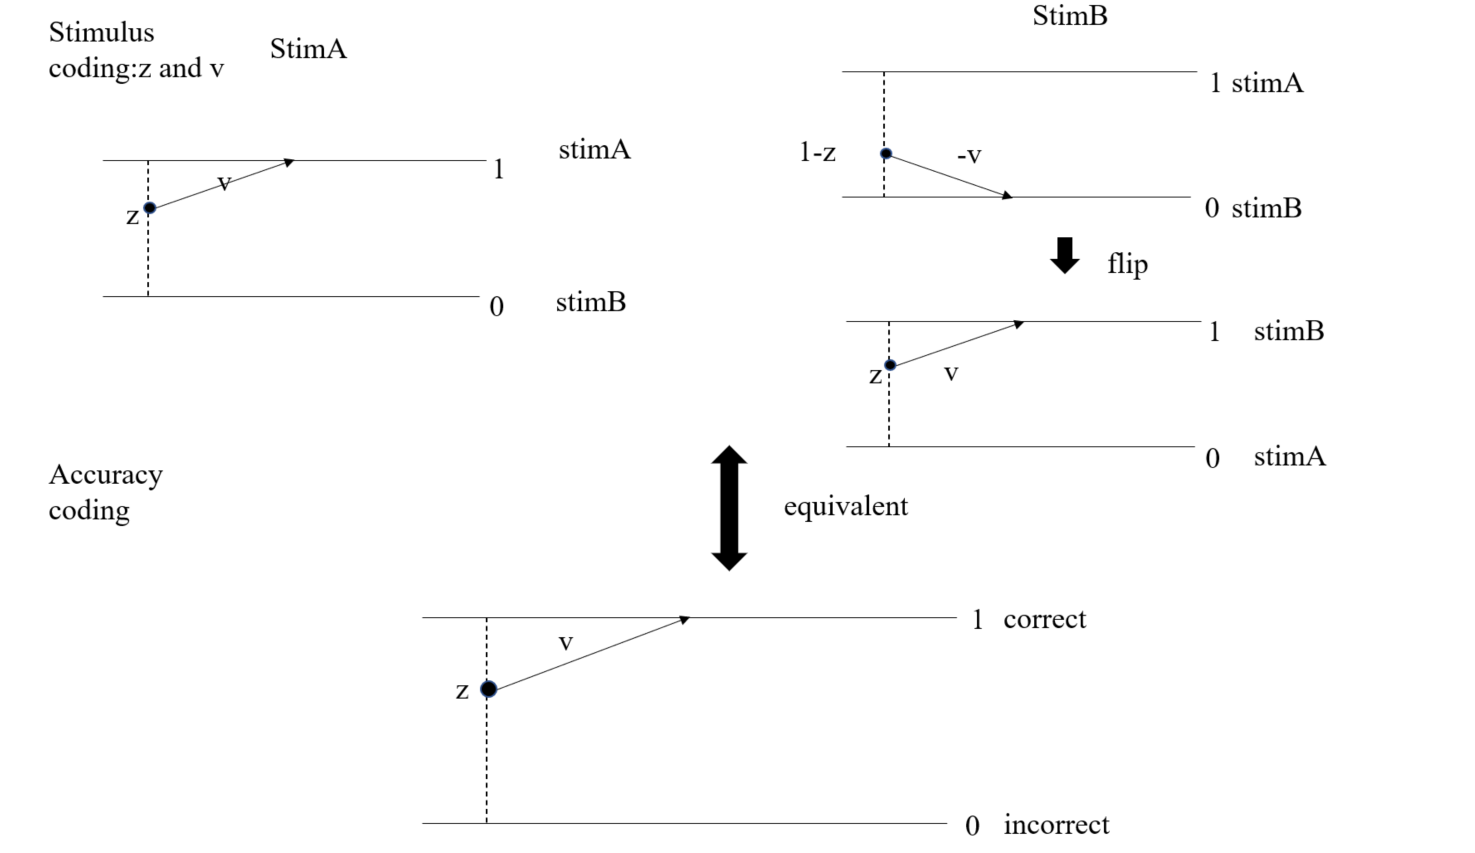

In [4]:
n_subjs=12
n_trials=50
effect=0
n_cond = 1

In [5]:
# generate params at population level
params = hddm.generate.gen_rand_params()
params['v_slope'] = effect
params['sv'] = 0
params['z'] = 0.7
del params['v']
reg_outcomes=['v']
share_noise = ('a','v','t','st','sz','sv','z', 'v_slope', 'v_inter')
group_params=[]

# set valid param ranges
bounds = {'a': (0, np.inf),
          'z': (0, 1),
          't': (0, np.inf), 
          'st': (0, np.inf),
          'sv': (0, np.inf),
          'sz': (0, 1)
}

In [6]:
data_ground = pd.DataFrame([])
ground_params = pd.DataFrame([])
# set different parameters
for params['v_inter'] in [0.5,1,1.5,2,2.5,3]:
    # generate subject-level parameters
    for i_subj in range(n_subjs):
        # generate params at subject level by normal distribution
        subj_params = kabuki.generate._add_noise({'none': params}, 
                                   noise=OrderedDict([('v', 0.2),
                                   ('a', 0.2),
                                   ('t', 0.1),
                                   ('sv', 0.1),
                                    ('z',0.1),
                                   ('v_inter', 0.1)]), 
                                   share_noise=share_noise,
                                            check_valid_func=hddm.utils.check_params_valid,
                                            bounds=bounds,
                                            exclude_params={'reg_outcomes', 'st', 'sv', 'sz'})['none']

        #generate v
        wfpt_params = deepcopy(subj_params)
        wfpt_params.pop('v_inter')
        effect = wfpt_params.pop('v_slope')
        x1 = np.random.randint(2,size=n_trials)
        x1 = np.arange(n_cond)
        wfpt_params['v'] = (effect*x1) + subj_params['v_inter']

        #generate rt and choice of each trial
        i_params = deepcopy(wfpt_params)
        sampled_rts = pd.DataFrame(np.zeros((n_trials, 2)), columns=['rt', 'response'])
        for i_sample in x1:
            #get current params
            for p in reg_outcomes:
                i_params[p] = wfpt_params[p][i_sample]
            #sample
            sampled_rts.iloc[(0+int(n_trials/n_cond)*i_sample):(int(n_trials/n_cond)+int(n_trials/n_cond)*i_sample),:] = hddm.generate.gen_rts(size=int(n_trials/n_cond), method='drift', dt=1e-3, **i_params).values
        sampled_rts['subj_idx']=i_subj
        sampled_rts['cov']=np.ones(int(n_trials))
        subj_data=sampled_rts

        # create dataframe
        subj_params = pd.DataFrame([subj_params])
        # add subject
        subj_params['subj_idx'] = i_subj
        subj_params['v']=wfpt_params['v'].mean()


        # param v
        subj_v = pd.DataFrame({'v':wfpt_params['v'],
                 'cov':x1,
                'subj_idx':i_subj})


        #concatante subj_data to group_data
        if i_subj == 0:
            group_params = subj_params
        else:
            group_params = pd.concat((group_params, subj_params), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            data = subj_data
        else:
            data = pd.concat((data, subj_data), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            wfpt_v = subj_v
        else:
            wfpt_v = pd.concat((wfpt_v, subj_v), ignore_index=True)
        data['ground'] = params['v_inter']
        group_params['ground'] = params['v_inter']
        
    data_ground = data_ground.append(data)
    ground_params = ground_params.append(group_params)

## Constructing the model and fitting it


Because we only assignate the effcet into parameter v, so our model only have one parameter vary with the covariance.

we write a function to call the parallel process to fit different sim data.

According to the simulation process, we assume all parameters only have a intercept. After fitting the model, we get the traces of the samples.

In [7]:
traces = pd.DataFrame([])

def ms1(vinter, samples=100, burn = 10, thin=2):
    dbname = f'mres_1_{vinter}.db'
    
    m = hddm.HDDMRegressor(data_ground.loc[data_ground['ground'] == vinter ], 
                           {'v~1','z~1','a~1','t~1'},
                           include=['z'],
                           group_only_regressors=False,
                           keep_regressor_trace=True,
                          )
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['ground']=vinter
    tc.to_csv(f'mres_1_{vinter}.csv',index=False)

    return m

In [8]:
ms1res = Parallel(n_jobs = 6)(delayed(ms1)(vinter = vinter, samples=2000,burn = 1000,thin=1) for vinter in np.unique(data_ground['ground']))

In [9]:
m1res_traces = pd.DataFrame([])
for vinter in np.unique(data_ground['ground']):
    m1res_trace = pd.read_csv(f'mres_1_{vinter}.csv')
    m1res_traces= m1res_traces.append(m1res_trace)

### Inspect the results

Then, we would like to inspect whether fitting result can recover the sim value.

Text(0, 0.5, 'fitted value')

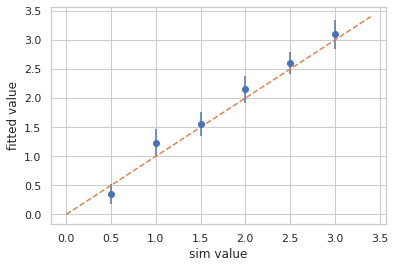

In [10]:
x = np.unique(m1res_traces['ground'])
y = m1res_traces.groupby('ground').v_Intercept.mean()
yerr = m1res_traces.groupby('ground').v_Intercept.std()
sns.scatterplot(x=x, 
                y=y,)
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(np.arange(0,3.5,0.1),
         np.arange(0,3.5,0.1),
        linestyle ="--" )
plt.xlabel('sim value')
plt.ylabel('fitted value')

x-axis is the sim value we set, and the y value is the fitted mean and std of the samples.

Diagonal line indicates that the two are equal.

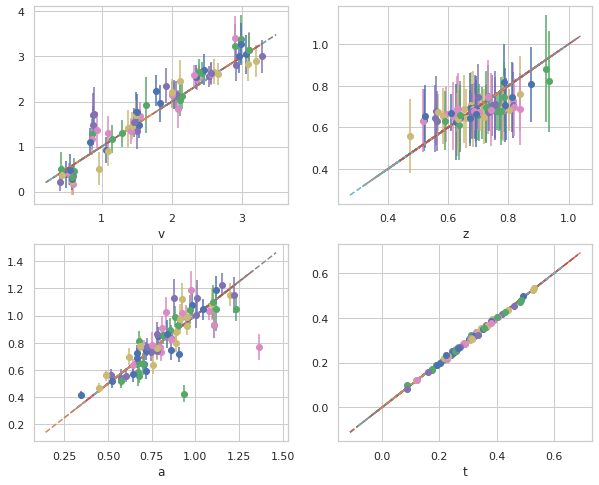

In [11]:
fig=plt.figure(figsize=(10,8))
for i,param in enumerate(['v','z','a','t']): 
    plt.subplot(2,2,i+1)
    for sim_value in np.unique(m1res_traces['ground']):
        for i_subj in np.unique(ground_params['subj_idx']):
            x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value),f'{param}']
            if param != 'z':
                y = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].mean()
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].std()
            else:
                y = 1/(1+np.exp(-(m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].mean())))
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].std()                
            sns.scatterplot(x=x, 
                            y=y,)
            plt.errorbar(x, y, yerr=yerr, fmt="o")
            plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     linestyle ="--" )

# stimulus coding, z bias

In this scenario, we assume the stim coding influence the parameter. z for stimA and 1-z for stimB. Other parameters are same.

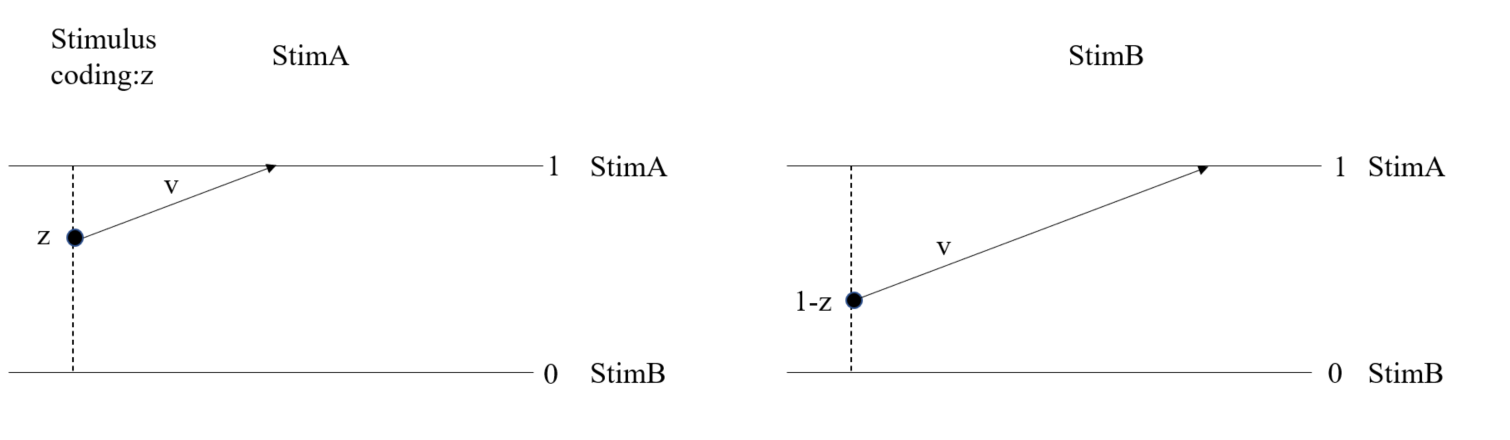

## Generate random parameter and performance

The step are as follows:

- set the parameters for the simulation according to the goal of the experiment.

- generate parameters of group level. Due to the existence of stimulus bias of z, so we set `z` for a stimulus and `1-z` for another stimulus. 

- Subject-level parameters are generated for each subject according to normal distribution based on group level parameters

Note: Multiple iterations of parameter values of interest have been used to test the robustness of the results.

In [12]:
n_subjs=12
n_trials=25
effect=0
n_cond = 1

In [13]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

In [51]:
data_stim =[]
group_params_stim =[]


# generate params at population level
params = hddm.generate.gen_rand_params()
params['v_slope'] = effect
params['v_inter'] = 1
params['sv'] = 0

del params['v']
reg_outcomes=['v']
share_noise = ('a','v','t','st','sz','sv','z', 'v_slope', 'v_inter')
group_params=[]

# set valid param ranges
bounds = {'a': (0, np.inf),
          'z': (0, 1),
          't': (0, np.inf), 
          'st': (0, np.inf),
          'sv': (0, np.inf),
          'sz': (0, 1)
    }
data_ground = pd.DataFrame([])
ground_params = pd.DataFrame([])
for z in [0.1,0.3,0.5,0.7,0.9]:
    for i_subj in range(n_subjs):
        for stim in [0,1]:
            # generate params at subject level
            if stim ==0:
                params['z'] = z
                subj_params_tmp = kabuki.generate._add_noise({'none': params}, 
                                           noise=OrderedDict([('v', 0.2),
                                           ('a', 0.2),
                                           ('t', 0.1),
                                           ('sv', 0.1),
                                            ('z',0.1),
                                           ('v_inter', 0.1)]), 
                                           share_noise=share_noise,
                                                    check_valid_func=hddm.utils.check_params_valid,
                                                    bounds=bounds,
                                                    exclude_params={'reg_outcomes', 'st', 'sv', 'sz'})['none']

            else:
                subj_params_tmp['z'] = 1 -  subj_params_tmp['z']

            #generate v
            wfpt_params = deepcopy(subj_params_tmp)
            wfpt_params.pop('v_inter')
            effect = wfpt_params.pop('v_slope')
            x1 = np.random.randint(2,size=n_trials)
            x1 = np.arange(n_cond)
            wfpt_params['v'] = (effect*x1) + subj_params_tmp['v_inter']

            #generate rt and choice of each trial
            i_params = deepcopy(wfpt_params)
            sampled_rts = pd.DataFrame(np.zeros((n_trials, 2)), columns=['rt', 'response'])
            for i_sample in x1:
                #get current params
                for p in reg_outcomes:
                    i_params[p] = wfpt_params[p][i_sample]
                #sample
                sampled_rts.iloc[(0+int(n_trials/n_cond)*i_sample):(int(n_trials/n_cond)+int(n_trials/n_cond)*i_sample),:] = hddm.generate.gen_rts(size=int(n_trials/n_cond), method='drift', dt=1e-3, **i_params).values
            sampled_rts['subj_idx']=i_subj
            sampled_rts['cov']=np.ones(int(n_trials))
            sampled_rts['stim']=stim
            subj_data=sampled_rts

            # create dataframe
            subj_params = pd.DataFrame([subj_params_tmp])
            # add subject
            subj_params['subj_idx'] = i_subj
            subj_params['v']=wfpt_params['v'].mean()
            subj_params['stim']=stim


            # param v
            subj_v = pd.DataFrame({'v':wfpt_params['v'],
                     'cov':x1,
                    'subj_idx':i_subj})


            if stim==0:    
                data_stim = subj_data
            else:
                data_stim = pd.concat((data_stim, subj_data), ignore_index=True)
            if stim == 0:
                group_params_stim = subj_params
            else:
                group_params_stim = pd.concat((group_params_stim, subj_params), ignore_index=True)





        #concatante subj_data to group_data
        if i_subj == 0:
            group_params = group_params_stim
        else:
            group_params = pd.concat((group_params, group_params_stim), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            data = data_stim
        else:
            data = pd.concat((data, data_stim), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            wfpt_v = subj_v
        else:
            wfpt_v = pd.concat((wfpt_v, subj_v), ignore_index=True)  

        data['ground'] = z
        group_params['ground'] = z
        
    data_ground = data_ground.append(data)
    ground_params = ground_params.append(group_params)

## Constructing the model and fitting it


Because we only assignate the effcet into parameter v, so our model only have one parameter vary with the covariance.

In [15]:
def z_link_func(x, data=df):
    stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stim.loc[x.index]},return_type='dataframe'))
    )
    # Apply z = (1 - x) to flip them along 0.5
    z_flip = np.subtract(stim, x.to_frame())
    # The above inverts those values we do not want to flip,
    # so invert them back
    z_flip[stim == 0] *= -1
    return z_flip

NameError: name 'df' is not defined

because we have many values to fit, so we write a function to call the parallel process.

According to the simulation process, we assume all parameters only have a intercept. z has a link function. 

After fitting the model, we get the traces of the samples.

In [16]:
traces = pd.DataFrame([])

def ms2(z, samples=100, burn = 10, thin=2):
    dbname = f'mres_1_{z}.db'
    
    df = data_ground.loc[data_ground['ground'] == z]
    
    def z_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stim.loc[x.index]},return_type='dataframe')))
        # Apply z = (1 - x) to flip them along 0.5
        z_flip = np.subtract(stim, x.to_frame())
        # The above inverts those values we do not want to flip,
        # so invert them back
        z_flip[stim == 0] *= -1
        return z_flip

    m = hddm.HDDMRegressor(df,
                       ['v~1',{'model':'z~1','link_func':z_link_func},'a~1','t~1'],
                       include=['z'],
                       group_only_regressors=False,
                       keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['ground']=z
    tc.to_csv(f'mres_2_{z}.csv',index=False)

    return m

In [17]:
ms2res = Parallel(n_jobs = 6)(delayed(ms2)(z = z, samples=2000,burn = 1000,thin=1) for z in np.unique(data_ground['ground']))

In [52]:
m1res_traces = pd.DataFrame([])
for z in np.unique(data_ground['ground']):
    m1res_trace = pd.read_csv(f'mres_2_{z}.csv')
    m1res_traces= m1res_traces.append(m1res_trace)

### Inspect the results

Then, we would like to inspect whether fitting result can recover the sim value.

Text(0, 0.5, 'fitted value')

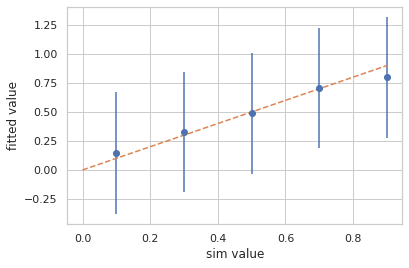

In [19]:
x = np.unique(m1res_traces['ground'])
y = 1/(1+np.exp(-(m1res_traces.groupby('ground').z_Intercept_trans.mean())))
yerr = 1/(1+np.exp(-(m1res_traces.groupby('ground').z_Intercept_trans.std())))
sns.scatterplot(x=x, 
                y=y,)
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(np.arange(0,1,0.1),
         np.arange(0,1,0.1),
        linestyle ="--" )
plt.xlabel('sim value')
plt.ylabel('fitted value')

x-axis is the sim value we set, and the y value is the fitted mean and std of the samples.

Diagonal line indicates that the two are equal.

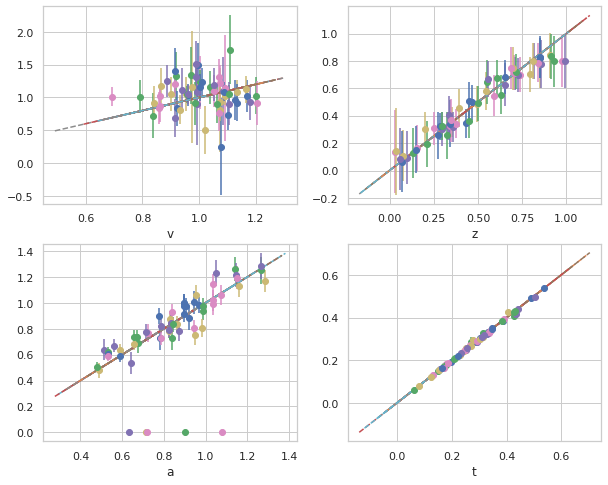

In [20]:
fig=plt.figure(figsize=(10,8))
for i,param in enumerate(['v','z','a','t']): 
    plt.subplot(2,2,i+1)
    for sim_value in np.unique(m1res_traces['ground']):
        for i_subj in np.unique(ground_params['subj_idx']):
            if param != 'z':
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),f'{param}']
                y = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].mean()
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].std()
            else:
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),f'{param}'] 
                y = 1/(1+np.exp(-(m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].mean())))
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].std()                
            sns.scatterplot(x=x, 
                            y=y,)
            plt.errorbar(x, y, yerr=yerr, fmt="o")
            plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     linestyle ="--" )

# stimulus coding, v bias, positive/negative

In this scenario, we assume the stim coding influence the parameter. v for stimA and -v for stimB. Other parameters are same.

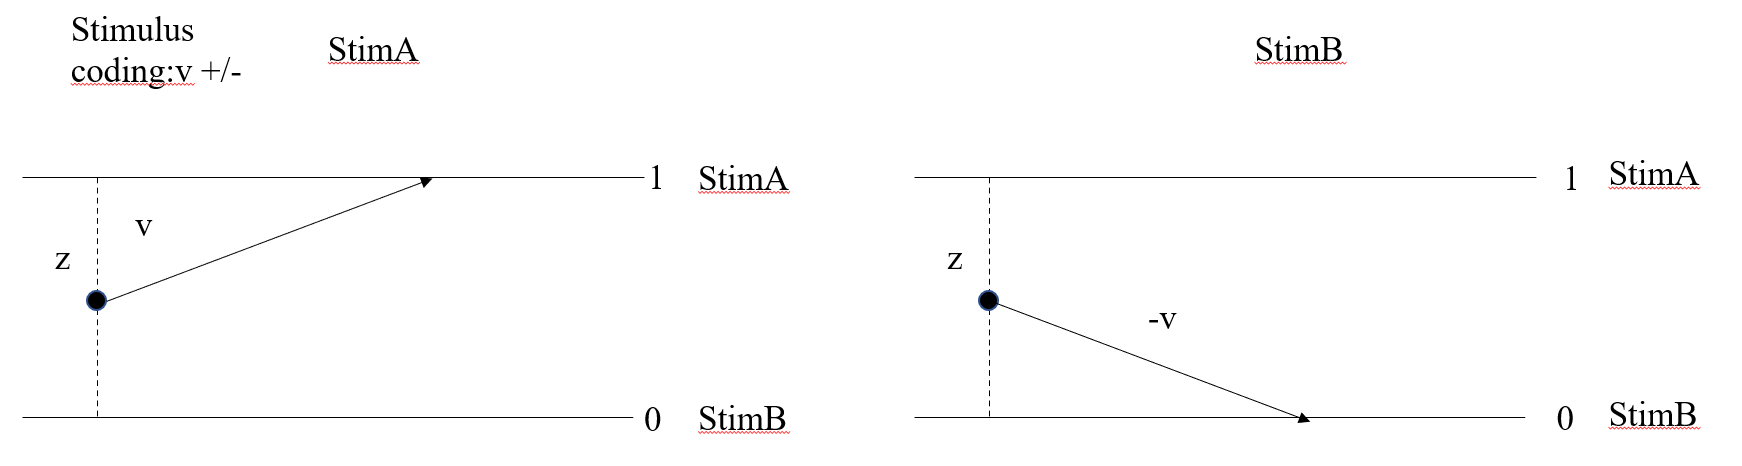

## Generate random parameter and performance

The step are as follows:

- set the parameters for the simulation according to the goal of the experiment.

- generate parameters of group level. Due to the existence of stimulus bias of v, so we set `v` for a stimulus and `-v` for another stimulus. 

- Subject-level parameters are generated for each subject according to normal distribution based on group level parameters

Note: Multiple iterations of parameter values of interest have been used to test the robustness of the results.

In [21]:
n_subjs=12
n_trials=50
effect=0
n_cond = 1

In [22]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

In [23]:
data_stim =[]
group_params_stim =[]


# generate params at population level
params = hddm.generate.gen_rand_params()
params['v_slope'] = effect
params['sv'] = 0

del params['v']
reg_outcomes=['v']
share_noise = ('a','v','t','st','sz','sv','z', 'v_slope', 'v_inter')
group_params=[]

# set valid param ranges
bounds = {'a': (0, np.inf),
          'z': (0, 1),
          't': (0, np.inf), 
          'st': (0, np.inf),
          'sv': (0, np.inf),
          'sz': (0, 1)
}
data_ground = pd.DataFrame([])
ground_params = pd.DataFrame([])
# set different parameters
for params['v_inter'] in [0.5,1,1.5,2,2.5,3]:
    for i_subj in range(n_subjs):
        for stim in [0,1]:
            # generate params at subject level
            if stim ==0:
                subj_params_tmp = kabuki.generate._add_noise({'none': params}, 
                                           noise=OrderedDict([('v', 0.2),
                                           ('a', 0.2),
                                           ('t', 0.1),
                                           ('sv', 0.1),
                                            ('z',0.1),
                                           ('v_inter', 0.1)]), 
                                           share_noise=share_noise,
                                                    check_valid_func=hddm.utils.check_params_valid,
                                                    bounds=bounds,
                                                    exclude_params={'reg_outcomes', 'st', 'sv', 'sz'})['none']

            else:
                subj_params_tmp['v_inter'] = -subj_params_tmp['v_inter']

            #generate v
            wfpt_params = deepcopy(subj_params_tmp)
            wfpt_params.pop('v_inter')
            effect = wfpt_params.pop('v_slope')
            x1 = np.random.randint(2,size=n_trials)
            x1 = np.arange(n_cond)
            wfpt_params['v'] = (effect*x1) + subj_params_tmp['v_inter']

            #generate rt and choice of each trial
            i_params = deepcopy(wfpt_params)
            sampled_rts = pd.DataFrame(np.zeros((n_trials, 2)), columns=['rt', 'response'])
            for i_sample in x1:
                #get current params
                for p in reg_outcomes:
                    i_params[p] = wfpt_params[p][i_sample]
                #sample
                sampled_rts.iloc[(0+int(n_trials/n_cond)*i_sample):(int(n_trials/n_cond)+int(n_trials/n_cond)*i_sample),:] = hddm.generate.gen_rts(size=int(n_trials/n_cond), method='drift', dt=1e-3, **i_params).values
            sampled_rts['subj_idx']=i_subj
            sampled_rts['cov']=np.ones(int(n_trials))
            sampled_rts['stim']=stim
            subj_data=sampled_rts

            # create dataframe
            subj_params = pd.DataFrame([subj_params_tmp])
            # add subject
            subj_params['subj_idx'] = i_subj
            subj_params['v']=wfpt_params['v'].mean()
            subj_params['stim']=stim


            # param v
            subj_v = pd.DataFrame({'v':wfpt_params['v'],
                     'cov':x1,
                    'subj_idx':i_subj})


            if stim==0:    
                data_stim = subj_data
            else:
                data_stim = pd.concat((data_stim, subj_data), ignore_index=True)
            if stim == 0:
                group_params_stim = subj_params
            else:
                group_params_stim = pd.concat((group_params_stim, subj_params), ignore_index=True)





        #concatante subj_data to group_data
        if i_subj == 0:
            group_params = group_params_stim
        else:
            group_params = pd.concat((group_params, group_params_stim), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            data = data_stim
        else:
            data = pd.concat((data, data_stim), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            wfpt_v = subj_v
        else:
            wfpt_v = pd.concat((wfpt_v, subj_v), ignore_index=True)  

        data['ground'] = params['v_inter']
        group_params['ground'] = params['v_inter']
        
    data_ground = data_ground.append(data)
    ground_params = ground_params.append(group_params)

## Constructing the model and fitting it


Because we only assignate the effcet into parameter v, so our model only have one parameter vary with the covariance.

because we have many values to fit, so we write a function to call the parallel process.

According to the simulation process, we assume all parameters only have a intercept. z has a link function. 

After fitting the model, we get the traces of the samples.

In [ ]:
def v_link_func(x, data=data_ground):
    stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                              {'s': data.stim.loc[x.index]},return_type='dataframe'))
    )
    v_flip = x.to_frame()
    v_flip[stim == 1] *= -1
    return v_flip

In [24]:
traces = pd.DataFrame([])

def ms3(vinter, samples=100, burn = 10, thin=2):
    dbname = f'mres_1_{vinter}.db'

    df = data_ground.loc[data_ground['ground'] == vinter]

    def v_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[0], [1]])',
                                  {'s': data.stim.loc[x.index]},return_type='dataframe'))
        )
        v_flip = x.to_frame()
        v_flip[stim == 1] *= -1
        return v_flip
    
    m = hddm.HDDMRegressor(df, 
                       ['z~1',{'model':'v~1','link_func':v_link_func},'a~1','t~1'],
                       include=['z'],
                       group_only_regressors=False,
                       keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['ground']=vinter
    tc.to_csv(f'mres_3_{vinter}.csv',index=False)

    return m

In [25]:
ms3res = Parallel(n_jobs = 6)(delayed(ms3)(vinter = vinter, samples=2000,burn = 1000,thin=1) for vinter in np.unique(data_ground['ground']))

In [26]:
m1res_traces = pd.DataFrame([])
for vinter in np.unique(data_ground['ground']):
    m1res_trace = pd.read_csv(f'mres_3_{vinter}.csv')
    m1res_traces= m1res_traces.append(m1res_trace)

### Inspect the results

Then, we would like to inspect whether fitting result can recover the sim value.

Text(0, 0.5, 'fitted value')

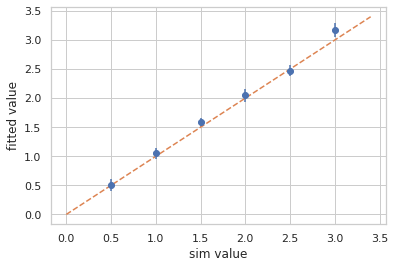

In [27]:
x = np.unique(m1res_traces['ground'])
y = m1res_traces.groupby('ground').v_Intercept.mean()
yerr = m1res_traces.groupby('ground').v_Intercept.std()
sns.scatterplot(x=x, 
                y=y,)
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(np.arange(0,3.5,0.1),
         np.arange(0,3.5,0.1),
        linestyle ="--" )
plt.xlabel('sim value')
plt.ylabel('fitted value')

x-axis is the sim value we set, and the y value is the fitted mean and std of the samples.

Diagonal line indicates that the two are equal.

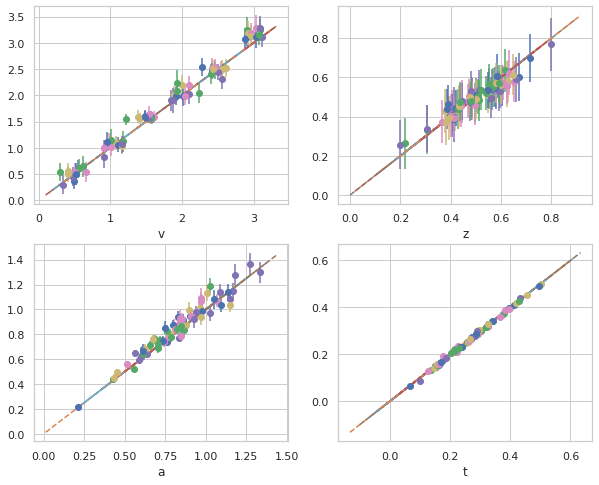

In [28]:
fig=plt.figure(figsize=(10,8))
for i,param in enumerate(['v','z','a','t']): 
    plt.subplot(2,2,i+1)
    for sim_value in np.unique(m1res_traces['ground']):
        for i_subj in np.unique(ground_params['subj_idx']):
            if param != 'z':
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),f'{param}']
                y = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].mean()
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].std()
            else:
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),f'{param}'] 
                y = 1/(1+np.exp(-(m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].mean())))
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].std()                
            sns.scatterplot(x=x, 
                            y=y,)
            plt.errorbar(x, y, yerr=yerr, fmt="o")
            plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     linestyle ="--" )

# stimulus coding, v bias, dc

In this scenario, we assume the stim coding influence the parameter. v+dc for stimA and -v+dc for stimB. Other parameters are same.

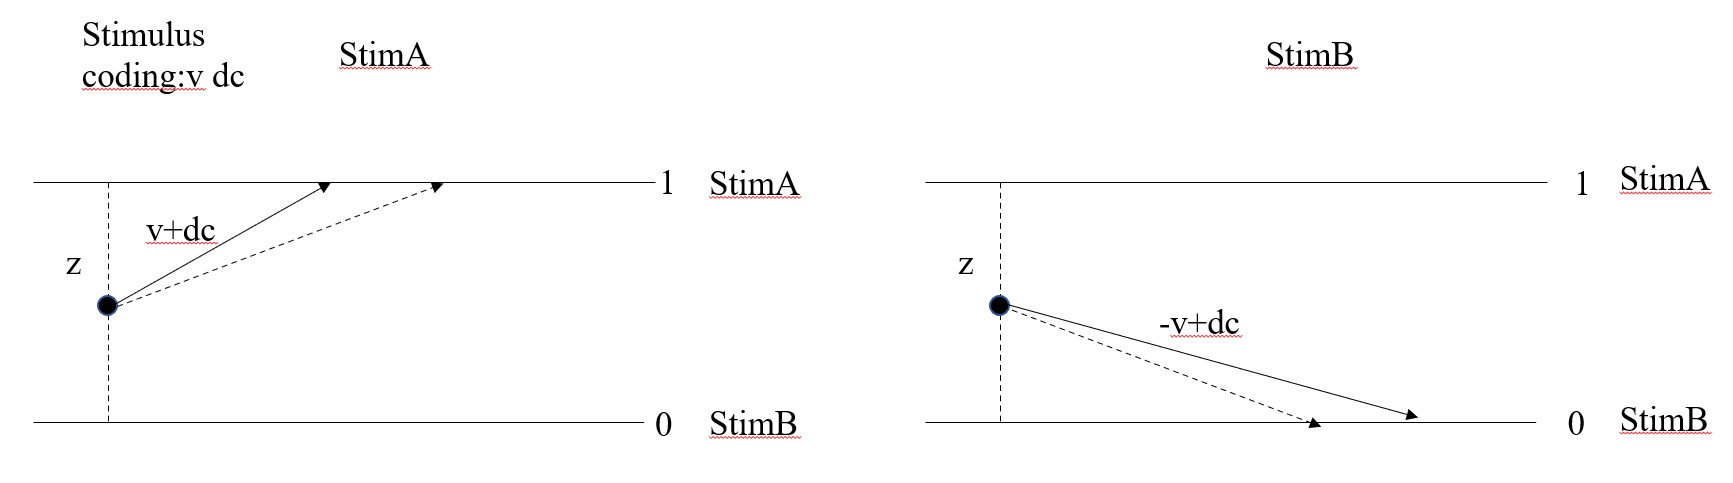

## Generate random parameter and performance

The step are as follows:

- set the parameters for the simulation according to the goal of the experiment.

- generate parameters of group level. Due to the existence of stimulus bias of v, so we set `v+dc` for a stimulus and `-v+dc` for another stimulus. 

- Subject-level parameters are generated for each subject according to normal distribution based on group level parameters

Note: Multiple iterations of parameter values of interest have been used to test the robustness of the results.

In [29]:
n_subjs=12
n_trials=50
effect=0
n_cond = 1

In [30]:
# set the figure theme
sns.set_theme(style="whitegrid")
# set random seed
np.random.seed(123)

In [31]:
data_stim =[]
group_params_stim =[]


# generate params at population level
params = hddm.generate.gen_rand_params()
params['v_slope'] = effect
params['sv'] = 0

del params['v']
reg_outcomes=['v']
share_noise = ('a','v','t','st','sz','sv','z', 'v_slope', 'v_inter')
group_params=[]

# set valid param ranges
bounds = {'a': (0, np.inf),
          'z': (0, 1),
          't': (0, np.inf), 
          'st': (0, np.inf),
          'sv': (0, np.inf),
          'sz': (0, 1)
}
data_ground = pd.DataFrame([])
ground_params = pd.DataFrame([])
# set different parameters
for dc in [0.2,0.4,0.6,0.8,1,1.2]:    
    for i_subj in range(n_subjs):
        for stim in [0,1]:
            # generate params at subject level
            if stim ==0:
                params['v_inter'] = 1
                subj_params_tmp = kabuki.generate._add_noise({'none': params}, 
                                           noise=OrderedDict([('v', 0.2),
                                           ('a', 0.2),
                                           ('t', 0.1),
                                           ('sv', 0.1),
                                            ('z',0.1),
                                           ('v_inter', 0.1)]), 
                                           share_noise=share_noise,
                                                    check_valid_func=hddm.utils.check_params_valid,
                                                    bounds=bounds,
                                                    exclude_params={'reg_outcomes', 'st', 'sv', 'sz'})['none']

                subj_params_tmp['v_inter'] = subj_params_tmp['v_inter']+dc
            else:
                subj_params_tmp['v_inter'] = 2*dc - subj_params_tmp['v_inter']

            #generate v
            wfpt_params = deepcopy(subj_params_tmp)
            wfpt_params.pop('v_inter')
            effect = wfpt_params.pop('v_slope')
            x1 = np.random.randint(2,size=n_trials)
            x1 = np.arange(n_cond)
            wfpt_params['v'] = (effect*x1) + subj_params_tmp['v_inter']

            #generate rt and choice of each trial
            i_params = deepcopy(wfpt_params)
            sampled_rts = pd.DataFrame(np.zeros((n_trials, 2)), columns=['rt', 'response'])
            for i_sample in x1:
                #get current params
                for p in reg_outcomes:
                    i_params[p] = wfpt_params[p][i_sample]
                #sample
                sampled_rts.iloc[(0+int(n_trials/n_cond)*i_sample):(int(n_trials/n_cond)+int(n_trials/n_cond)*i_sample),:] = hddm.generate.gen_rts(size=int(n_trials/n_cond), method='drift', dt=1e-3, **i_params).values
            sampled_rts['subj_idx']=i_subj
            sampled_rts['cov']=np.ones(int(n_trials))
            sampled_rts['stim']=stim
            subj_data=sampled_rts

            # create dataframe
            subj_params = pd.DataFrame([subj_params_tmp])
            # add subject
            subj_params['subj_idx'] = i_subj
            subj_params['v']=wfpt_params['v'].mean()
            subj_params['stim']=stim


            # param v
            subj_v = pd.DataFrame({'v':wfpt_params['v'],
                     'cov':x1,
                    'subj_idx':i_subj})


            if stim==0:    
                data_stim = subj_data
            else:
                data_stim = pd.concat((data_stim, subj_data), ignore_index=True)
            if stim == 0:
                group_params_stim = subj_params
            else:
                group_params_stim = pd.concat((group_params_stim, subj_params), ignore_index=True)





        #concatante subj_data to group_data
        if i_subj == 0:
            group_params = group_params_stim
        else:
            group_params = pd.concat((group_params, group_params_stim), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            data = data_stim
        else:
            data = pd.concat((data, data_stim), ignore_index=True)

        #concatante subj_data to group_data
        if i_subj == 0:
            wfpt_v = subj_v
        else:
            wfpt_v = pd.concat((wfpt_v, subj_v), ignore_index=True)  

        data['ground'] = dc
        group_params['ground'] = dc
        
    data_ground = data_ground.append(data)
    ground_params = ground_params.append(group_params)

## Constructing the model and fitting it


Because we only assignate the effcet into parameter v, so our model only have one parameter vary with the covariance.

Due to dc is a freedom parameter, we cannot use link function to transform, so we try to add a term of stim in linear regressor. $v \sim 1+stim$

we recode the stim as 1 and -1, and use link function.

for stim = 1, $v \sim \beta_0+\beta_1$

for stim = -1, $v \sim \beta_0-\beta_1$, after link function, it is $-\beta_0 + \beta_1$

$\beta_1$ is dc

In [32]:
data

,rt,response,subj_idx,cov,stim,ground
0,0.606485,0.0,0,1.0,0,1.2
1,0.290349,1.0,0,1.0,0,1.2
2,0.616349,1.0,0,1.0,0,1.2
3,0.254349,1.0,0,1.0,0,1.2
4,0.282349,1.0,0,1.0,0,1.2
...,...,...,...,...,...,...
1195,0.089218,0.0,11,1.0,1,1.2
1196,0.103218,0.0,11,1.0,1,1.2
1197,0.133218,0.0,11,1.0,1,1.2
1198,0.285531,1.0,11,1.0,1,1.2


In [ ]:
def v_link_func(x, data=data_ground):
    stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                              {'s': data_ground.stim.loc[x.index]},return_type='dataframe')))
    return x.to_frame()*stim

In [33]:
traces = pd.DataFrame([])

def ms4(dc, samples=100, burn = 10, thin=2):
    dbname = f'mres_1_{dc}.db'
    
    df = data_ground.loc[data_ground['ground'] == dc]
    
    df.stim = np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                              {'s': df.stim.loc[df.rt.index]},return_type='dataframe'))
    
    def v_link_func(x, data=df):
        stim = (np.asarray(dmatrix('0 + C(s, [[1], [-1]])',
                                  {'s': df.stim.loc[x.index]},return_type='dataframe')))
        return x.to_frame()*stim
    
    m = hddm.HDDMRegressor(df, 
                       ['z~1',{'model':'v~1+stim','link_func':v_link_func},'a~1','t~1'],
                       include=['z'],
                       group_only_regressors=False,
                       keep_regressor_trace=True,)
    # find the starting point
    m.find_starting_values()
    # MCMC sample
    m.sample(samples, 
             burn=burn, 
             thin=thin, 
             dbname=dbname,
             db='pickle')
    # save traces
    tc = m.get_traces()
    tc['ground']=dc
    tc.to_csv(f'mres_4_{dc}.csv',index=False)

    return m

In [34]:
ms4res = Parallel(n_jobs = 6)(delayed(ms4)(dc = dc, samples=2000,burn = 1000,thin=1) for dc in np.unique(data_ground['ground']))

In [35]:
m1res_traces = pd.DataFrame([])
for dc in np.unique(data_ground['ground']):
    m1res_trace = pd.read_csv(f'mres_4_{dc}.csv')
    m1res_traces= m1res_traces.append(m1res_trace)

In [36]:
m1res_traces

,z_Intercept_trans,z_Intercept_std,z_Intercept_subj_trans.0,z_Intercept_subj_trans.1,z_Intercept_subj_trans.2,z_Intercept_subj_trans.3,z_Intercept_subj_trans.4,z_Intercept_subj_trans.5,z_Intercept_subj_trans.6,z_Intercept_subj_trans.7,...,t_Intercept_subj.3,t_Intercept_subj.4,t_Intercept_subj.5,t_Intercept_subj.6,t_Intercept_subj.7,t_Intercept_subj.8,t_Intercept_subj.9,t_Intercept_subj.10,t_Intercept_subj.11,ground
0,-0.075315,0.277579,0.747792,-0.415174,-0.075740,0.579188,-0.245305,0.334181,0.589380,-0.004225,...,0.313350,0.209438,0.186978,0.278189,0.343567,0.442734,0.353571,0.192764,0.320298,0.2
1,-0.076257,0.272324,0.541889,-0.151106,0.045806,0.176588,-0.195437,0.189001,0.586955,0.142213,...,0.308778,0.209200,0.185934,0.284951,0.351708,0.439477,0.351821,0.200922,0.320781,0.2
2,-0.023262,0.268796,0.308351,-0.555502,0.084375,0.446505,-0.273628,0.227133,0.638525,-0.093662,...,0.317973,0.211342,0.187444,0.282821,0.358938,0.438363,0.348730,0.199169,0.319845,0.2
3,-0.088709,0.247184,0.378471,-0.214885,0.102927,0.449827,-0.249623,0.107568,0.489008,-0.311670,...,0.314939,0.208534,0.191111,0.280714,0.366694,0.428958,0.349677,0.201275,0.320210,0.2
4,0.067375,0.281639,0.411457,-0.643137,0.116843,0.439170,-0.301040,0.322268,0.559945,0.039555,...,0.312694,0.210108,0.190709,0.283806,0.357198,0.438487,0.356085,0.193774,0.321779,0.2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.231328,0.256653,0.235130,0.396161,-0.396858,0.870626,0.245867,0.462246,0.853096,0.514418,...,0.250283,0.365216,0.317471,0.317180,0.211414,0.274333,0.326033,0.263761,0.063720,1.2
996,0.199514,0.256572,-0.184436,0.296809,-0.581521,0.838157,0.267387,0.372662,0.971412,0.635106,...,0.251028,0.363503,0.310601,0.316551,0.210307,0.274788,0.324791,0.265985,0.065146,1.2
997,0.239886,0.249770,-0.265085,0.478524,-0.271187,0.988573,0.167644,0.458437,0.964341,0.551704,...,0.244607,0.362250,0.312165,0.315257,0.211492,0.276875,0.327410,0.250616,0.058553,1.2
998,0.366404,0.265608,-0.264550,0.551802,-0.197685,1.283967,0.302462,0.594636,0.963871,0.484192,...,0.253861,0.363391,0.312877,0.314999,0.210326,0.267727,0.326931,0.254547,0.063380,1.2


### Inspect the results

Then, we would like to inspect whether fitting result can recover the sim value.

Text(0, 0.5, 'fitted value')

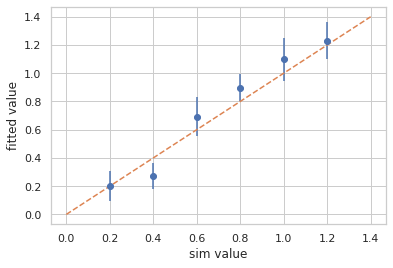

In [37]:
x = np.unique(m1res_traces['ground'])
y = -m1res_traces.groupby('ground').v_stim.mean()
yerr = m1res_traces.groupby('ground').v_stim.std()
sns.scatterplot(x=x, 
                y=y,)
plt.errorbar(x, y, yerr=yerr, fmt="o")
plt.plot(np.arange(0,1.5,0.2),
         np.arange(0,1.5,0.2),
        linestyle ="--" )
plt.xlabel('sim value')
plt.ylabel('fitted value')

x-axis is the sim value we set, and the y value is the fitted mean and std of the samples.

Diagonal line indicates that the two are equal.

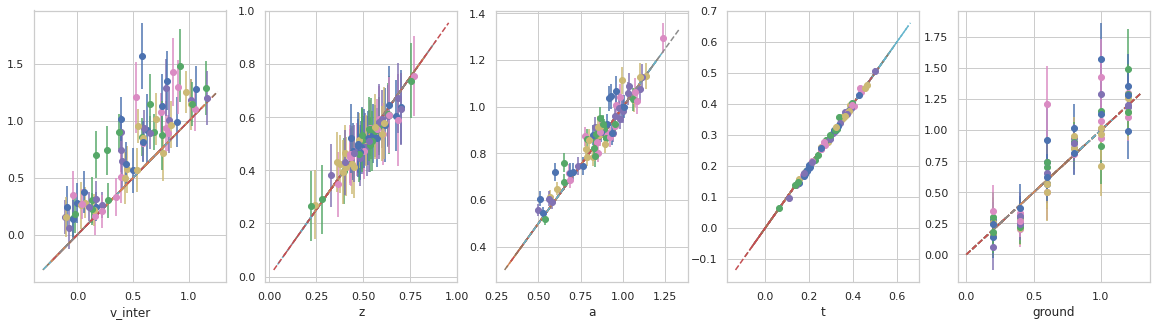

In [47]:
fig=plt.figure(figsize=(20,5))
for i,param in enumerate(['v','z','a','t','dc']): 
    plt.subplot(1,5,i+1)
    for sim_value in np.unique(m1res_traces['ground']):
        for i_subj in np.unique(ground_params['subj_idx']):
            if (param == 't') or (param == 'a'):
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==1),f'{param}']
                y = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].mean()
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj.{i_subj}'].std()
            elif param == 'dc':
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),'ground']
                y = -m1res_traces.loc[m1res_traces['ground']==sim_value,f'v_stim_subj.{i_subj}'].mean()
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'v_stim_subj.{i_subj}'].std()
            elif param =='v':
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),'v_inter']-dc
                y = -m1res_traces.loc[m1res_traces['ground']==sim_value,f'v_stim_subj.{i_subj}'].mean()
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'v_stim_subj.{i_subj}'].std()
            else:
                x = ground_params.loc[(ground_params['subj_idx']==i_subj)&(ground_params['ground']==sim_value)&(ground_params['stim']==0),f'{param}'] 
                y = 1/(1+np.exp(-(m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].mean())))
                yerr = m1res_traces.loc[m1res_traces['ground']==sim_value,f'{param}_Intercept_subj_trans.{i_subj}'].std()                
            sns.scatterplot(x=x, 
                            y=y,)
            plt.errorbar(x, y, yerr=yerr, fmt="o")
            plt.plot(np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     np.arange(min(x)-0.2,max(x)+0.2,0.1),
                     linestyle ="--" )